In [1]:
import pandas as pd
import numpy as np 
import os
import sys

sys.path.append("..")
DATA_DIR = "~/Desktop/code/data/"

## Method 0

Taking the single nearest neighbor as a starting point; returns the media name / composition / concentrations of the nearest media

In [2]:
# Model ouptut when K-Neighbors classifier n_neighbors=1
model = pd.read_csv(os.path.join(DATA_DIR, "one-neighbor-test.csv"))

df = model[["taxon_id", "Test Cluster", "RF Classify", "KNN Classify", "neighbor_media_id", "neighbor_taxon_id", "Media Cluster"]]
df = df.rename(columns={
    "Test Cluster": "KM_cluster",
    "RF Classify": "RF_cluster",
    "KNN Classify": "KN_cluster"
})

df.head()

,taxon_id,KM_cluster,RF_cluster,KN_cluster,neighbor_media_id,neighbor_taxon_id,Media Cluster
0,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,J654,438.0,NaN
1,KBase_derived_Bin.001.fastaBA_S_extracted_bins...,163,163,163,1076b,28127.0,32.0
2,KBase_derived_Bin.001.fastaCF_F_extracted_bins...,138,138,138,J256,1496.0,NaN
3,KBase_derived_Bin.001.fastaCG_S_extracted_bins...,138,138,138,600a,2966552.0,23.0
4,KBase_derived_Bin.001.fastaFE_F_extracted_bins...,163,163,163,1076b,28127.0,32.0


In [5]:
# Updated media dataframe with concentrations (where available)
media_info = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete.csv"))

# Explode and format
media_exploded = media_info.explode(['components', 'component_ids', 'component_gL'])
media_exploded.reset_index(drop=True, inplace=True)
md_df = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete-explo.csv"))
md_df = md_df[["media_id", "components", "component_ids", "component_gL", "steps"]]

# Merge with the neighbor data
merged = df.merge(md_df, left_on='neighbor_media_id', right_on='media_id', how='left') #or md_grouped rather than md_df
merged.head()

,taxon_id,KM_cluster,RF_cluster,KN_cluster,neighbor_media_id,neighbor_taxon_id,Media Cluster,media_id,components,component_ids,component_gL,steps
0,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,J654,438.0,NaN,J654,KH2PO4,11.0,0.50,[[{'step': 'Mix components thoroughly and auto...
1,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,J654,438.0,NaN,J654,NH4Cl,42.0,1.00,[[{'step': 'Mix components thoroughly and auto...
2,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,J654,438.0,NaN,J654,Na2SO4,110.0,4.50,[[{'step': 'Mix components thoroughly and auto...
3,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,J654,438.0,NaN,J654,CaCl2 x 2 H2O,7.0,0.06,[[{'step': 'Mix components thoroughly and auto...
4,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,J654,438.0,NaN,J654,MgSO4 x 7 H2O,8.0,0.06,[[{'step': 'Mix components thoroughly and auto...


In [7]:
# Filter for one sample
bin = "Bin.003.fastaCG_F"
filter = merged["taxon_id"].str.contains(bin) # TEST SAMPLE OF INTEREST
sample = merged[filter]

# Drop all forms of water (clutter)
water = sample["components"].str.contains("water")
recipe = sample[~water]
recipe = recipe[["media_id", "components", "component_ids", "component_gL", "steps"]]
#recipe.to_csv(os.path.join(DATA_DIR, "recipe_test.csv"), index=False)

print("Suggested recipe for {}:".format(bin))
recipe

# Can check accuracy/missing concentrations/steps from https://mediadive.dsmz.de/rest/medium/{media_id}

Suggested recipe for Bin.003.fastaCG_F:


,media_id,components,component_ids,component_gL,steps
401,J363,Salt Solution I,1143.0,NaN,[[{'step': 'Adjust pH to 6.7. Prepare medium a...
402,J363,Salt Solution II,1144.0,NaN,[[{'step': 'Adjust pH to 6.7. Prepare medium a...
403,J363,Trypticase peptone,124.0,9.960160,[[{'step': 'Adjust pH to 6.7. Prepare medium a...
404,J363,Yeast extract,16.0,4.980080,[[{'step': 'Adjust pH to 6.7. Prepare medium a...
405,J363,Glucose,5.0,0.249004,[[{'step': 'Adjust pH to 6.7. Prepare medium a...
406,J363,Cellobiose,214.0,0.249004,[[{'step': 'Adjust pH to 6.7. Prepare medium a...
407,J363,Maltose,171.0,0.249004,[[{'step': 'Adjust pH to 6.7. Prepare medium a...
408,J363,Starch,199.0,0.249004,[[{'step': 'Adjust pH to 6.7. Prepare medium a...
409,J363,Sodium resazurin,1852.0,NaN,[[{'step': 'Adjust pH to 6.7. Prepare medium a...
410,J363,Na2CO3,32.0,NaN,[[{'step': 'Adjust pH to 6.7. Prepare medium a...


## Method 1

(Initially manual, can automate with new concentrations) 
For each EC number, map the ranges of concentrations used for the respective media (one media component at a time shown)

### Construction

In [2]:
# Load dataframe with CoCl2 media concentrations
cocl = pd.read_csv(os.path.join(DATA_DIR, "concentrations", "CoCl2_trimmed.csv"))

# Load dataframe with EC annotations
ec = pd.read_csv(os.path.join(DATA_DIR, "taxa2ec-final.csv"), low_memory=False)

# Merge these dataframes to associate ec values w/ concentrations
coan = pd.merge(left=cocl, right=ec, on="media_id", how="left")
coec = coan.dropna(subset=["ec"])
filter = coec["ec"].str.contains("-")
coec = coec[~filter]

coec.head()

,solution,media_id,CoCl2,species,taxon_id,source,ec
0,Media,150a,0.6,Acidithiobacillus caldus,1736.0,uniprot,2.4.1.13
13,Allen,88a,0.0,Vulcanisaeta distributa,220670.0,uniprot,2.5.1.157
14,Allen,88a,0.0,Vulcanisaeta distributa,220670.0,uniprot,5.4.99.25
21,Allen,358a,0.0,Acidianus ambivalens,70586.0,uniprot,1.8.5.2
22,Allen,358a,0.0,Acidianus ambivalens,70586.0,uniprot,1.8.5.2


### Output

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

df = coec.copy()
ec_range = df.groupby('ec')['CoCl2'].agg(['min', 'max']).reset_index()
ec_range.columns = ['EC Number', 'Min Concentration', 'Max Concentration']

# Initialize
fig = go.Figure()

# Error bars
fig.add_trace(go.Scatter(
    x=ec_range['EC Number'],
    y=(ec_range['Max Concentration'] + ec_range['Min Concentration']) / 2,  # Mean concentration for y-axis
    error_y=dict(
        type='data',
        symmetric=False,
        array=(ec_range['Max Concentration'] - ec_range['Min Concentration']) / 2,
        arrayminus=(ec_range['Max Concentration'] - ec_range['Min Concentration']) / 2
    ),
    mode='markers',
    marker=dict(color='blue'),
    text=ec_range['EC Number'],  # Hover text
    hoverinfo='text',  # Show hover text
    name='Concentration Range'
))

# Update layout
fig.update_layout(
    title='Concentration Range for Each EC Number',
    xaxis_title='EC Number',
    yaxis_title='Concentration',
    xaxis_tickangle=-45
)

fig.show()

In [4]:
#TODO: add ability to map a test-set over this (maybe just highlight present EC numbers)

## Method 2

Collaborative Filtering (needs work)

### Construction

In [5]:
# Retrieve all available media from MediaDive
md_media_df = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-media.csv")) # also has pH ranges...

# Create media_id_list
md_media_df = md_media_df.rename(columns={"id": "media_id"})
media_id_list = md_media_df["media_id"].astype(str).unique()

print(len(media_id_list), "unique media IDs")

# Retrieve solution/concentration info from MediaDive (run once, load after)
#import modules.mediadive as md
#media_info = md.get_concentrations(media_id_list)
#media_info.to_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete.csv"), index=False)

media_info = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete.csv"))
media_info.head()

3322 unique media IDs


,media_id,solutions,solution_names,components,component_ids,component_gL,steps,sub_solutions,solution_ids,solution_ml
0,1,[1],['Main sol. 1'],"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]","[5, 3, 15, None]","[[{'step': 'Adjust pH to 7.0.'}, {'step': 'For...",[],[],[]
1,1a,[3],['Main sol. 1a'],"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]","[5, 3, 15, None]",[[{'step': 'Adjust pH to 7.0. For Bacillus str...,[],[],[]
2,2,"[4, 1]","['Main sol. 2', 'Main sol. 1']","['Urea', 'Peptone', 'Meat extract', 'Agar', 'D...","[339, 1, 2, 3, 4]","[20, 5, 3, 15, None]",[[{'step': 'To medium 1 add 20 g/l urea before...,['Main sol. 1'],[1],[1000]
3,3,[5],['Main sol. 3'],"['Glucose', 'Mannitol', 'CaCl2 x 2 H2O', 'MgSO...","[5, 6, 7, 8, 9, 10, 11, 12, 13, 3, 4]","[5, 5, 0.1, 0.1, 0.005, 0.9, 0.1, 0.01, 5, 15,...","[[{'step': 'Adjust pH to 7.3.'}, {'step': 'Ste...",[],[],[]
4,6,[6],['Main sol. 6'],"['K2HPO4', 'KH2PO4', 'MgSO4 x 7 H2O', 'CaCl2 x...","[10, 11, 8, 7, 12, 14, 15, 3, 4]","[0.8, 0.2, 0.5, 0.05, 0.01, 0.001, 20, 15, None]",[None],[],[],[]


In [6]:
# Explode on the components
media_exploded = media_info.explode(['components', 'component_ids', 'component_gL'])
media_exploded.reset_index(drop=True, inplace=True)
#media_exploded.to_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete-explo.csv"), index=False)

# Format dataframe for collaborative filtering
md_df = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete-explo.csv"))
md_df = md_df[["media_id", "components", "component_ids", "component_gL"]]

# Aggregate concentrations (component_gL) by summing duplicate component_ids for each media (occurs when multiple solutions w/ same ingredient)
md_grouped = md_df.groupby(['media_id', 'component_ids'], as_index=False).agg({'component_gL': 'sum'})

# Pivot (\/) ( ;,,;)(\/) whopp oop oop oop oop
concentrations = md_grouped.pivot(index='media_id', columns='component_ids', values='component_gL')

#concentrations.to_csv(os.path.join(DATA_DIR, "mediadive", "all-media-concentrations.csv"))
md_media_df = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-media.csv"))
print(len(md_media_df), "total media,", len(concentrations), "with component_ids provided.")

concentrations.head()

3322 total media, 3134 with component_ids provided.


component_ids,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,2371.0,2375.0,2378.0,2384.0,2388.0,2389.0,2391.0,2394.0,2397.0,2398.0
media_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,15.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,15.0,0.0,20.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,0.0,NaN,NaN,0.014,0.34,0.01,0.014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,0.0,NaN,NaN,0.100,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Taxa-EC / media dataframe
df = pd.read_csv(os.path.join(DATA_DIR, "model", "ml_input.csv"), low_memory=False)

filter = df["ec"].str.contains("-")
df = df[~filter]

df = df[["taxon_id", "media_id", "ec"]].value_counts().reset_index()
df = df.pivot(index=["taxon_id", "media_id"], columns="ec", values="count")
df = df.fillna(0.0).reset_index()

# Filtering out MAGs
bins = df["media_id"].str.contains("unknown")
taxa2ec = df[~bins]

# Sum/aggregate by media_id
ec_grouped = taxa2ec.groupby('media_id', as_index=False).sum()

print(len(ec_grouped), "unique media_id's with associated taxa.")
ec_counts = ec_grouped.drop('taxon_id', axis=1)
ec_counts.to_csv(os.path.join(DATA_DIR, "mediadive", "comp_mapping", "ec-abundances.csv"), index=False)
ec_grouped.head()

581 unique media_id's with associated taxa.


ec,media_id,taxon_id,1.1.1.1,1.1.1.100,1.1.1.101,1.1.1.102,1.1.1.103,1.1.1.105,1.1.1.107,1.1.1.108,...,7.6.2.12,7.6.2.13,7.6.2.14,7.6.2.15,7.6.2.16,7.6.2.2,7.6.2.5,7.6.2.7,7.6.2.8,7.6.2.9
0,1012a,126734.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1031a,1794699.02142.0216932.0216933.0216934.0216937....,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,104a,306.0651822.066228.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,104b,1408819.01450156.01470356.01492.01501.01502.01...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,104c,1278232.01470354.0154288.0179628.01869227.0194...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


media_id overlap


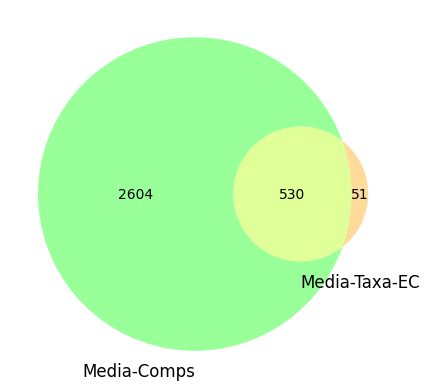

In [8]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

media = concentrations.index
taxa = ec_grouped["media_id"].to_list()

venn2(
    subsets=[set(media), set(taxa)],
    set_labels=["Media-Comps", "Media-Taxa-EC"],
    set_colors=["lime", "orange"]
    )

print("media_id overlap")

In [9]:
# List of media_id's w/ associated taxa, but no recipe in the MediaDive API (can manually check .pdf's)
media = concentrations.index
overlap = ec_grouped["media_id"].isin(media)
excluded_media = ec_grouped[~overlap]
omed = excluded_media["media_id"].to_list()

print(len(omed), "excluded media_ids")

# Add the omitted IDs to the concentration dataframe to prepare for merging
omed_ids = pd.DataFrame({'media_id': omed})
medcomp = concentrations.reset_index()
media_comps = pd.concat([medcomp, omed_ids], ignore_index=True) 

media_comps.to_csv(os.path.join(DATA_DIR, "mediadive", "comp_mapping", "media-concentrations.csv"), index=False)
media_comps

51 excluded media_ids


,media_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,2371.0,2375.0,2378.0,2384.0,2388.0,2389.0,2391.0,2394.0,2397.0,2398.0
0,1,5.0,3.0,15.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,NaN,NaN,15.0,0.0,20.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000,NaN,NaN,NaN,0.0,NaN,NaN,0.014,0.34,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001,NaN,NaN,NaN,0.0,NaN,NaN,0.100,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1002,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3180,J894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3181,J934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3182,J960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3183,J972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
medcon = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "comp_mapping", "media-concentrations.csv")) # media concentrations
ecabun = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "comp_mapping", "ec-abundances.csv")) # sum of ec's for media-associated taxon

df_combined = pd.merge(medcon, ecabun, on="media_id")
df_combined

,media_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,7.6.2.12,7.6.2.13,7.6.2.14,7.6.2.15,7.6.2.16,7.6.2.2,7.6.2.5,7.6.2.7,7.6.2.8,7.6.2.9
0,1012a,NaN,NaN,12.0,0.0,NaN,NaN,0.30,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1031a,NaN,NaN,20.0,0.0,NaN,10.0,52.80,10.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,104a,NaN,NaN,NaN,0.0,NaN,NaN,0.25,0.5,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,104b,NaN,NaN,NaN,0.0,NaN,NaN,0.25,0.5,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,104c,NaN,NaN,NaN,0.0,NaN,NaN,0.25,0.5,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,J894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
577,J934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
578,J960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
579,J972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
from sklearn.decomposition import TruncatedSVD
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# Applying an SVD model to predict concentrations:
df = df_combined.set_index('media_id')
df_cleaned = df.dropna(axis=1, how='all')

# Imputation Model
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(df_cleaned)
n_components = min(data_imputed.shape) - 1  # Use one less than the smaller dimension
svd = TruncatedSVD(n_components=n_components)

media_matrix = svd.fit_transform(data_imputed)
ingredient_matrix = svd.components_
reconstructed_data = np.dot(media_matrix, ingredient_matrix)

data_filled_svd = np.where(np.isnan(df_cleaned.values), reconstructed_data, df_cleaned.values)
svd_output = pd.DataFrame(data_filled_svd, index=df_cleaned.index, columns=df_cleaned.columns)

svd_output

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,7.6.2.12,7.6.2.13,7.6.2.14,7.6.2.15,7.6.2.16,7.6.2.2,7.6.2.5,7.6.2.7,7.6.2.8,7.6.2.9
media_id,,,,,,,,,,,,,,,,,,,,,
1012a,4.144383,4.055556,12.000000,0.000000e+00,6.879133,17.5,0.30000,43.667059,0.043801,15.326166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1031a,4.144383,4.055556,20.000000,0.000000e+00,6.879133,10.0,52.80000,10.000000,0.043801,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104a,4.144383,4.055556,15.564965,0.000000e+00,6.879133,17.5,0.25000,0.500000,0.043801,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104b,4.144383,4.055556,15.564965,0.000000e+00,6.879133,17.5,0.25000,0.500000,0.043801,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104c,4.144383,4.055556,15.564965,0.000000e+00,6.879133,17.5,0.25000,0.500000,0.043801,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
J894,4.144383,4.055556,15.564965,-5.944294e-14,6.879133,17.5,1.81717,43.667059,0.043801,15.326166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J934,4.144383,4.055556,15.564965,-6.247341e-14,6.879133,17.5,1.81717,43.667059,0.043801,15.326166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
J960,4.144383,4.055556,15.564965,-6.115253e-14,6.879133,17.5,1.81717,43.667059,0.043801,15.326166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Test Sample

In [12]:
# Formatting a test sample:
ml_input = pd.read_csv(os.path.join(DATA_DIR, "model", "ml_input.csv"), low_memory=False)

bins = ml_input["source"].str.contains("KBase")
mag = ml_input[bins]
test = mag["taxon_id"].str.contains("Bin.001.fastaBA_F_") # selecting individual MAG
sample = mag[test]

sample["count"] = 1
new_sample = sample.pivot_table(index='taxon_id', columns='ec', values='count', fill_value=0)
new_sample.reset_index(inplace=True)
new_sample = new_sample.rename(columns={"taxon_id": "media_id"})

new_sample.head()

C:\Users\jakel\AppData\Local\Temp\ipykernel_11460\2661495130.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ec,media_id,1.1.1.141,1.1.1.23,1.1.1.25,1.1.1.267,1.1.1.3,1.1.1.31,1.1.1.85,1.1.1.86,1.1.1.94,...,6.6.1.1,6.6.1.2,7.1.1.2,7.1.1.9,7.1.2.2,7.3.2.1,7.3.2.2,7.3.2.5,7.3.2.6,7.4.2.8
0,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Output

In [13]:
# Apply the same imputation model
df_new_sample = new_sample.set_index('media_id')
df_new_sample = df_new_sample.reindex(columns=df_cleaned.columns, fill_value=0)

data_new_sample_imputed = imputer.transform(df_new_sample)
media_matrix_new = svd.transform(data_new_sample_imputed)
reconstructed_data_new = np.dot(media_matrix_new, svd.components_)

df_reconstructed_new = pd.DataFrame(reconstructed_data_new, index=df_new_sample.index, columns=df_cleaned.columns)
df_reconstructed_new.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,7.6.2.12,7.6.2.13,7.6.2.14,7.6.2.15,7.6.2.16,7.6.2.2,7.6.2.5,7.6.2.7,7.6.2.8,7.6.2.9
media_id,,,,,,,,,,,,,,,,,,,,,
KBase_derived_Bin.001.fastaBA_F_extracted_bins.AssemblySet_DRAM.gff,-7.911286e-15,2.853545e-14,-2.325591e-15,0.007218,5.563448e-15,-1.365675e-14,-1.532628e-14,6.402474e-17,-6.688022e-13,1.539499e-16,...,-0.002295,0.017305,0.447325,-0.013047,0.011521,0.026925,0.05749,0.052979,-0.117274,-0.015624


In [14]:
# Only show components above a threshold of a certain value
threshold = 0.05 # e.g., don't show components with concentrations below 0.5 g/L

df_filtered = df_reconstructed_new[df_reconstructed_new > threshold]
df_filtered_cleaned = df_filtered.dropna(axis=1, how='all')
df_filtered_cleaned = df_filtered_cleaned.dropna(axis=0, how='all')

df_filtered_cleaned.head()

,24.0,45.0,94.0,96.0,115.0,135.0,149.0,339.0,421.0,702.0,...,7.4.2.8,7.4.2.9,7.5.2.10,7.5.2.11,7.5.2.13,7.5.2.7,7.6.2.11,7.6.2.14,7.6.2.5,7.6.2.7
media_id,,,,,,,,,,,,,,,,,,,,,
KBase_derived_Bin.001.fastaBA_F_extracted_bins.AssemblySet_DRAM.gff,0.079969,0.159097,0.059464,0.146081,0.067324,0.124784,0.090293,0.411334,0.052126,0.273212,...,0.390843,0.107971,0.132405,0.200665,0.170672,0.181072,0.173863,0.447325,0.05749,0.052979


NOTE: method 2 currently appears to drastically underreport concentrations; need to find a middle-ground between methods 1 and 2

## Method 3

Using the means of clusters (or nearest neighbors?) to predict media component concentrations for each sample

### Construction

In [15]:
ml_output = pd.read_csv(os.path.join(DATA_DIR, "model", "ml-model-output.csv"))

#df = ml_output.drop(ml_output.columns[0:32], axis=1)
df = ml_output[["taxon_id", "Test Cluster", "RF Classify", "KNN Classify", "neighbor_taxon_id", "neighbor_media_id"]]
df = df.rename(columns={
    "taxon_id": "bin_name", 
    "Test Cluster": "KM_cluster",
    "RF Classify": "RF_cluster",
    "KNN Classify": "KN_cluster"
    #"neighbor_media_id": "media_id"
})

df.head()

,bin_name,KM_cluster,RF_cluster,KN_cluster,neighbor_taxon_id,neighbor_media_id
0,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,438.0,J654
1,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,33018.0,J92
2,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,65958.0,J960
3,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,1520.0,87a
4,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,589382.0,J27


In [16]:
media_info = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete.csv"))

# Explode on the components
media_exploded = media_info.explode(['components', 'component_ids', 'component_gL'])
media_exploded.reset_index(drop=True, inplace=True)
#media_exploded.to_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete-explo.csv"), index=False)

# Format dataframe for collaborative filtering
md_df = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete-explo.csv"))
md_df = md_df[["media_id", "components", "component_ids", "component_gL"]]

# Aggregate concentrations (component_gL) by summing duplicate component_ids for each media (occurs when multiple solutions w/ same ingredient)
#md_grouped = md_df.groupby(['media_id', 'component_ids'], as_index=False).agg({'component_gL': 'sum'})

# Merge with the neighbor data
merged = df.merge(md_df, left_on='neighbor_media_id', right_on='media_id', how='left') #or md_grouped rather than md_df
merged.head()

,bin_name,KM_cluster,RF_cluster,KN_cluster,neighbor_taxon_id,neighbor_media_id,media_id,components,component_ids,component_gL
0,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,438.0,J654,J654,KH2PO4,11.0,0.50
1,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,438.0,J654,J654,NH4Cl,42.0,1.00
2,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,438.0,J654,J654,Na2SO4,110.0,4.50
3,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,438.0,J654,J654,CaCl2 x 2 H2O,7.0,0.06
4,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,438.0,J654,J654,MgSO4 x 7 H2O,8.0,0.06


In [17]:
df_means = merged.groupby(['bin_name', 'KM_cluster', 'RF_cluster', 'KN_cluster', 'components', 'component_ids'])['component_gL'].mean().reset_index()
df_means.head()

,bin_name,KM_cluster,RF_cluster,KN_cluster,components,component_ids,component_gL
0,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,(NH4)2SO4,27.0,2.997000
1,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,Biotin,46.0,0.050000
2,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,Ca(NO3)2,266.0,0.009990
3,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,CaCl2 x 2 H2O,7.0,0.053809
4,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,Calcium pantothenate,518.0,0.500000


### Output

In [18]:
# Filter through different test bins for media output based on nearest neighbors
test = df_means["bin_name"].str.contains("Bin.001.fastaBA_F_e")
test_df = df_means[test]
test_df.head()

#TODO: combine with taxonomy data? i.e., take nearest neighbors taxonomy info into account 

,bin_name,KM_cluster,RF_cluster,KN_cluster,components,component_ids,component_gL
0,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,(NH4)2SO4,27.0,2.997000
1,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,Biotin,46.0,0.050000
2,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,Ca(NO3)2,266.0,0.009990
3,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,CaCl2 x 2 H2O,7.0,0.053809
4,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,138,138,138,Calcium pantothenate,518.0,0.500000


### TRAIN_TEST_SPLIT

In [8]:
ml_output = pd.read_csv(os.path.join(DATA_DIR, "model", "param-model-output.csv"))
#df = ml_output.drop(ml_output.columns[0:32], axis=1)
df = ml_output[["Target", "Test Cluster", "RF Classify", "KNN Classify", "neighbor_media_id", "neighbor_media_cluster"]]
df = df.rename(columns={
    "Test Cluster": "KM_cluster",
    "RF Classify": "RF_cluster",
    "KNN Classify": "KN_cluster"
})

df

,Target,KM_cluster,RF_cluster,KN_cluster,neighbor_media_id,neighbor_media_cluster
0,J52,14,14,14,J346,NaN
1,J52,14,14,14,J346,NaN
2,J52,14,14,14,J43,NaN
3,J52,14,14,14,J346,NaN
4,J52,14,14,14,J346,NaN
...,...,...,...,...,...,...
8460,J475,76,76,76,220a,5.0
8461,J475,76,76,76,J346,NaN
8462,J475,76,76,76,J118,13.0
8463,J475,76,76,76,J118,13.0


In [29]:
media_info = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete.csv"))

# Explode on the components
media_exploded = media_info.explode(['components', 'component_ids', 'component_gL'])
media_exploded.reset_index(drop=True, inplace=True)
#media_exploded.to_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete-explo.csv"), index=False)

# Format dataframe for collaborative filtering
md_df = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete-explo.csv"))
md_df = md_df[["media_id", "components", "component_ids", "component_gL"]]

# Aggregate concentrations (component_gL) by summing duplicate component_ids for each media (occurs when multiple solutions w/ same ingredient)
#md_grouped = md_df.groupby(['media_id', 'component_ids'], as_index=False).agg({'component_gL': 'sum'})

# Merge with the neighbor data
merged = df.merge(md_df, left_on='neighbor_media_id', right_on='media_id', how='left') #or md_grouped rather than md_df
merged.head()

,Target,KM_cluster,RF_cluster,KN_cluster,neighbor_media_id,neighbor_media_cluster,media_id,components,component_ids,component_gL
0,J52,14,14,14,J346,NaN,J346,Yeast extract,16.0,0.5
1,J52,14,14,14,J346,NaN,J346,Proteose peptone no. 3,316.0,0.5
2,J52,14,14,14,J346,NaN,J346,Casamino acids,101.0,0.5
3,J52,14,14,14,J346,NaN,J346,Glucose,5.0,0.5
4,J52,14,14,14,J346,NaN,J346,Starch,199.0,0.5


In [43]:
# Filter for one sample
filter = merged["Target"].str.contains("104b") # TEST SAMPLE OF INTEREST
sample = merged[filter]

# Group components and calculate the mean concentration 
df_means = sample.groupby(['Target', 'components', 'component_ids'])['component_gL'].mean().reset_index()

# Drop all forms of water (clutter)
water = df_means["components"].str.contains("water")
recipe = df_means[~water]

#recipe.to_csv(os.path.join(DATA_DIR, "recipe_test.csv"), index=False)
recipe 

#TODO: compare to actual 104b recipe and calculate a percent similarity metric, find way to automate this to compare between all samples?

,Target,components,component_ids,component_gL
0,104b,(NH4)2SO4,27.0,2.970300
1,104b,Agar,3.0,14.416667
2,104b,Beef extract,85.0,10.000000
3,104b,CaCO3,13.0,20.000000
4,104b,CaCl2 x 2 H2O,7.0,0.182216
5,104b,Casamino acids,101.0,3.250000
6,104b,CuSO4 x 5 H2O,121.0,0.000495
7,104b,Czapek-Dox liquid medium,1610.0,33.400000
8,104b,D-Glucose,211.0,5.000000
11,104b,Fastidious Anaerobe Basal Broth,1079.0,35.400000


# Method 4

In [39]:
# Search for media with trace element solutions

media_df = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete.csv"), low_memory=False)

trace_element = media_df["sub_solutions"].str.contains("trace")
trace_media = media_df[trace_element]
te_list = trace_media["media_id"].to_list()

trace_media.head()

,media_id,solutions,solution_names,components,component_ids,component_gL,steps,sub_solutions,solution_ids,solution_ml
85,88,"[154, 155]","['Main sol. 88', ""Allen's trace element soluti...","['(NH4)2SO4', 'KH2PO4', 'MgSO4 x 7 H2O', 'CaCl...","[27, 11, 8, 7, 82, 16, 4, 36, 196, 35, 39, 9, ...","[1.28713, 0.277228, 0.247525, 0.0693069, 0.019...",[[{'step': 'Dissolve ingredients (except yeast...,"[""Allen's trace element solution""]",[155],[10]
86,88a,"[156, 155]","['Main sol. 88a', ""Allen's trace element solut...","['(NH4)2SO4', 'KH2PO4', 'MgSO4 x 7 H2O', 'CaCl...","[27, 11, 8, 7, 82, 80, 16, 54, 4, 36, 196, 35,...","[1.3, 0.28, 0.25, 0.07, 0.02, 10, 0.5, 0.5, No...",[[{'step': 'Dissolve ingredients (except sulfu...,"[""Allen's trace element solution""]",[155],[10]
87,88b,"[5562, 155]","['Main sol. 88b', ""Allen's trace element solut...","['(NH4)2SO4', 'KH2PO4', 'MgSO4 x 7 H2O', 'CaCl...","[27, 11, 8, 7, 82, 4, 80, 16, 199, 25, 54, 36,...","[1.3, 0.28, 0.25, 0.07, 0.02, None, 1, 0.2, 2,...","[[{'step': 'Prepare medium , then add (per lit...","[""Allen's trace element solution""]",[155],[10]
88,88c,"[158, 155]","['Main sol. 88c', ""Allen's trace element solut...","['(NH4)2SO4', 'KH2PO4', 'MgSO4 x 7 H2O', 'CaCl...","[27, 11, 8, 7, 82, 65, 16, 164, 101, 54, 4, 36...","[1.3, 0.28, 0.25, 0.07, 0.02, 2, 1, 1, 0.5, 0....",[[{'step': 'Dissolve ingredients (except thios...,"[""Allen's trace element solution""]",[155],[10]
184,182,"[308, 155]","['Main sol. 182', ""Allen's trace element solut...","['Yeast extract', 'Casamino acids', 'KH2PO4', ...","[16, 101, 11, 27, 8, 7, 4, 36, 196, 35, 39, 9,...","[1, 1, 3.1, 2.5, 0.2, 0.25, None, 0.18, 0.45, ...",[[{'step': 'Dissolve all compounds except yeas...,"[""Allen's trace element solution""]",[155],[10]


In [41]:
# Find prediction results for those media

df = pd.read_csv(os.path.join(DATA_DIR, "TEST1.csv"))

df = df.rename(columns={"neighbor_media_id": "media_id"})
filter = df["media_id"].isin(te_list)
df = df[filter]

print(len(df))

prediction = pd.merge(left=df, right=trace_media, on="media_id", how="left")
prediction

0


,Test Cluster,taxon_id,KNN Classify,RF Classify,media_id,neighbor_taxon_id,Media Cluster,solutions,solution_names,components,component_ids,component_gL,steps,sub_solutions,solution_ids,solution_ml


Note: it appears none of the suggested neighboring media currently have trace element solutions included as sub-solutions, regardless, let's take our main outlier as a test case:

In [83]:
df = pd.read_csv(os.path.join(DATA_DIR, "TEST1.csv"))
media_df = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-complete-explo.csv"), low_memory=False)

df = df.rename(columns={"neighbor_media_id": "media_id"})
boi = df["taxon_id"].str.contains("Bin.003.fastaCG_F")
data = df[boi]

prediction = pd.merge(left=data, right=media_df, on="media_id", how="left")
prediction

,Test Cluster,taxon_id,KNN Classify,RF Classify,media_id,neighbor_taxon_id,Media Cluster,solutions,solution_names,components,component_ids,component_gL,steps,sub_solutions,solution_ids,solution_ml
0,67,KBase_derived_Bin.003.fastaCG_F_extracted_bins...,67,67,J363,2499157.0,NaN,[4084],['Main sol. J363'],Salt Solution I,1143.0,NaN,[[{'step': 'Adjust pH to 6.7. Prepare medium a...,[],[],[]
1,67,KBase_derived_Bin.003.fastaCG_F_extracted_bins...,67,67,J363,2499157.0,NaN,[4084],['Main sol. J363'],Salt Solution II,1144.0,NaN,[[{'step': 'Adjust pH to 6.7. Prepare medium a...,[],[],[]
2,67,KBase_derived_Bin.003.fastaCG_F_extracted_bins...,67,67,J363,2499157.0,NaN,[4084],['Main sol. J363'],Trypticase peptone,124.0,9.960160,[[{'step': 'Adjust pH to 6.7. Prepare medium a...,[],[],[]
3,67,KBase_derived_Bin.003.fastaCG_F_extracted_bins...,67,67,J363,2499157.0,NaN,[4084],['Main sol. J363'],Yeast extract,16.0,4.980080,[[{'step': 'Adjust pH to 6.7. Prepare medium a...,[],[],[]
4,67,KBase_derived_Bin.003.fastaCG_F_extracted_bins...,67,67,J363,2499157.0,NaN,[4084],['Main sol. J363'],Glucose,5.0,0.249004,[[{'step': 'Adjust pH to 6.7. Prepare medium a...,[],[],[]
5,67,KBase_derived_Bin.003.fastaCG_F_extracted_bins...,67,67,J363,2499157.0,NaN,[4084],['Main sol. J363'],Cellobiose,214.0,0.249004,[[{'step': 'Adjust pH to 6.7. Prepare medium a...,[],[],[]
6,67,KBase_derived_Bin.003.fastaCG_F_extracted_bins...,67,67,J363,2499157.0,NaN,[4084],['Main sol. J363'],Maltose,171.0,0.249004,[[{'step': 'Adjust pH to 6.7. Prepare medium a...,[],[],[]
7,67,KBase_derived_Bin.003.fastaCG_F_extracted_bins...,67,67,J363,2499157.0,NaN,[4084],['Main sol. J363'],Starch,199.0,0.249004,[[{'step': 'Adjust pH to 6.7. Prepare medium a...,[],[],[]
8,67,KBase_derived_Bin.003.fastaCG_F_extracted_bins...,67,67,J363,2499157.0,NaN,[4084],['Main sol. J363'],Sodium resazurin,1852.0,NaN,[[{'step': 'Adjust pH to 6.7. Prepare medium a...,[],[],[]
9,67,KBase_derived_Bin.003.fastaCG_F_extracted_bins...,67,67,J363,2499157.0,NaN,[4084],['Main sol. J363'],Na2CO3,32.0,NaN,[[{'step': 'Adjust pH to 6.7. Prepare medium a...,[],[],[]


Let's map some cofactor concentrations:

In [58]:
# Load ec and cofactor info

trco = pd.read_csv(os.path.join(DATA_DIR, "cofactors", "cofactors-taxa.csv"), low_memory=False)
trco = trco[["Query EC", "CofactorExtracted", "Fe-S cluster", "CofactorFinal"]]
trco = trco.rename(columns={"Query EC": "ec"})

trta = pd.read_csv(os.path.join(DATA_DIR, "model", "ml_input.csv"), low_memory=False)

cfdf = pd.merge(left=trta, right=trco, on="ec", how="left")

cfdf.head()

,media_id,species,taxon_id,source,ec,CofactorExtracted,Fe-S cluster,CofactorFinal
0,1a,Comamonas testosteroni,1886637.0,uniprot,2.6.1.1,NaN,NaN,NaN
1,1a,Comamonas testosteroni,1886637.0,uniprot,4.1.1.12,NaN,NaN,NaN
2,1a,Comamonas testosteroni,1886637.0,uniprot,1.13.11.74,Fe(2+),False,Fe
3,1a,Comamonas testosteroni,1886637.0,uniprot,1.13.11.76,Fe(2+),False,Fe
4,1a,Comamonas testosteroni,1886637.0,uniprot,1.14.13.23,NaN,NaN,NaN


In [70]:
# Focus on metals / trace elements:
metals = pd.read_csv(os.path.join(DATA_DIR, "cofactors", "metals-list.csv"))
meli = metals["Metals"].to_list()
filter = cfdf["CofactorFinal"].isin(meli)
meco = cfdf[filter]
meco

,media_id,species,taxon_id,source,ec,CofactorExtracted,Fe-S cluster,CofactorFinal
2,1a,Comamonas testosteroni,1886637.0,uniprot,1.13.11.74,Fe(2+),False,Fe
3,1a,Comamonas testosteroni,1886637.0,uniprot,1.13.11.76,Fe(2+),False,Fe
7,1a,Comamonas testosteroni,1886637.0,uniprot,1.1.9.1,Ca(2+),False,Ca
8,1a,Comamonas testosteroni,1886637.0,uniprot,1.1.9.1,heme c,False,Fe
15,1a,Comamonas testosteroni,1886637.0,uniprot,1.14.12.15,Fe cation,False,Fe
...,...,...,...,...,...,...,...,...
4797907,unknown,unknown,KBase_derived_Bin.039.fastaLS_S_extracted_bins...,KBase,4.2.99.18,Mg(2+),False,Mg
4797908,unknown,unknown,KBase_derived_Bin.039.fastaLS_S_extracted_bins...,KBase,4.2.99.18,Zn(2+),False,Zn
4797914,unknown,unknown,KBase_derived_Bin.039.fastaLS_S_extracted_bins...,KBase,2.7.1.107,Mg(2+),False,Mg
4797917,unknown,unknown,KBase_derived_Bin.039.fastaLS_S_extracted_bins...,KBase,3.1.21.7,Mg(2+),False,Mg


Now: need a list of each trace element solution utilizing these ~90+ cofactors, and then 1) map the distributions of these concentrations (linear regression, just plot means, distributions, etc.), align these values with the "CofactorFinal", and attempt for a given test case to be able to suggest concentrations based on the EC numbers present (similar to Method 1, but needs refinement)

In [75]:
comp = meco[["media_id", "taxon_id", "source", "ec", "CofactorFinal"]]
comp = comp.dropna()

In [78]:
# Filters
bins = comp["source"].str.contains("KBase") # Separate MAGs from training database
boi = comp["taxon_id"].str.contains("Bin.003.fastaCG_F") # Isolate a single test MAG

co = comp[~bins]
ct = comp[bins]
test = comp[boi]

#Create, merge, format counts 
coct = co["CofactorFinal"].value_counts().reset_index()
sum1 = coct["count"].sum(axis=0)
coct['ratio1'] = coct['count'].div(sum1)
coct = coct.rename(columns={"count": "count1"})

ctct = ct["CofactorFinal"].value_counts().reset_index()
sum2 = ctct["count"].sum(axis=0)
ctct['ratio2'] = ctct['count'].div(sum2)
ctct = ctct.rename(columns={"count": "count2"})

tect = test["CofactorFinal"].value_counts().reset_index()
sum3 = tect["count"].sum(axis=0)
tect['ratio3'] = tect['count'].div(sum3)
tect = tect.rename(columns={"count": "count3"})

cf_df = pd.merge(left=coct, right=ctct, on="CofactorFinal", how="left")
cf_df = pd.merge(left=cf_df, right=tect, on="CofactorFinal", how="left")
cf_df = cf_df.fillna(0)

x = cf_df["count1"].sum(axis=0)
y = cf_df["count2"].sum(axis=0)
z = cf_df["count3"].sum(axis=0)
print(x, "annotated bin cofactors", y, "annotated database cofactors")

#cf_df.to_csv("~/Desktop/cofactors.csv", index=False)
cf_df.head()

1652619 annotated bin cofactors 94312.0 annotated database cofactors


,CofactorFinal,count1,ratio1,count2,ratio2,count3,ratio3
0,Mg,419329,0.253736,30229.0,0.320521,23.0,0.328571
1,Zn,292936,0.177256,13681.0,0.145061,16.0,0.228571
2,Fe,234396,0.141833,19240.0,0.204004,12.0,0.171429
3,Mn,173112,0.104750,7622.0,0.080817,6.0,0.085714
4,Ca,128564,0.077794,5946.0,0.063046,1.0,0.014286


In [79]:
relabeled_cofactors = cf_df.copy()
dictionary = {
    "a monovalent": "UM",
    "metal": "UM"
}

for key in dictionary.keys():
    relabeled_cofactors["CofactorFinal"] = relabeled_cofactors["CofactorFinal"].str.replace(key, dictionary[key])

relabeled_cofactors = relabeled_cofactors.groupby(['CofactorFinal'])[['count1', 'ratio1', 'count2', 'ratio2', 'count3', 'ratio3']].sum().reset_index()
relabeled_cofactors = relabeled_cofactors.sort_values(['count1'], ascending=[False])
relabeled_cofactors.head()

,CofactorFinal,count1,ratio1,count2,ratio2,count3,ratio3
6,Mg,419329,0.253736,30229.0,0.320521,23.0,0.328571
15,Zn,292936,0.177256,13681.0,0.145061,16.0,0.228571
3,Fe,234396,0.141833,19240.0,0.204004,12.0,0.171429
7,Mn,173112,0.104750,7622.0,0.080817,6.0,0.085714
0,Ca,128564,0.077794,5946.0,0.063046,1.0,0.014286


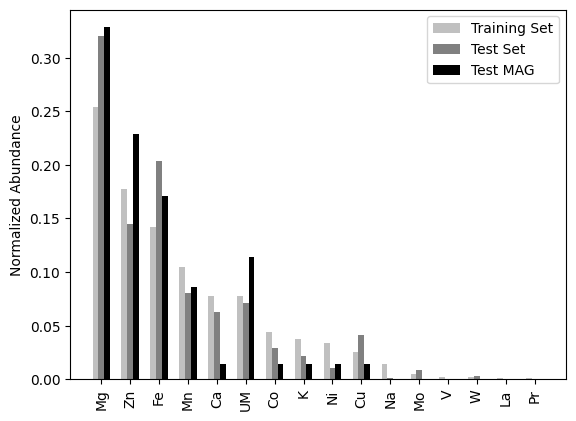

In [80]:
import numpy as np 
import matplotlib.pyplot as plt 

data = relabeled_cofactors
N = len(data)
ind = np.arange(N)  
width = 0.2
  
xvals = data['ratio1']
bar1 = plt.bar(ind, xvals, width, color = 'silver') 
  
yvals = data['ratio2']
bar2 = plt.bar(ind+width, yvals, width, color='grey') 

zvals = data['ratio3']
bar3 = plt.bar(ind+width*2, zvals, width, color='black') 

plt.xticks(ind+width, data["CofactorFinal"], rotation=90) 
plt.ylabel("Normalized Abundance")
plt.legend((bar1, bar2, bar3), ('Training Set', 'Test Set', 'Test MAG'))

plt.gca().set_facecolor('white') 

plt.show() 

# End

In [2]:
med = pd.read_csv(os.path.join(DATA_DIR, "model", "ml_input.csv"), low_memory=False)
med
media_list = med["media_id"].to_list()
medmed = set(media_list)
print(len(medmed)-1)

646


In [3]:
med

,media_id,species,taxon_id,source,ec
0,1a,Comamonas testosteroni,1886637.0,uniprot,2.6.1.1
1,1a,Comamonas testosteroni,1886637.0,uniprot,4.1.1.12
2,1a,Comamonas testosteroni,1886637.0,uniprot,1.13.11.74
3,1a,Comamonas testosteroni,1886637.0,uniprot,1.13.11.76
4,1a,Comamonas testosteroni,1886637.0,uniprot,1.14.13.23
...,...,...,...,...,...
1778640,unknown,unknown,KBase_derived_Bin.039.fastaLS_S_extracted_bins...,KBase,2.7.1.107
1778641,unknown,unknown,KBase_derived_Bin.039.fastaLS_S_extracted_bins...,KBase,1.7.2.5
1778642,unknown,unknown,KBase_derived_Bin.039.fastaLS_S_extracted_bins...,KBase,3.2.1.81
1778643,unknown,unknown,KBase_derived_Bin.039.fastaLS_S_extracted_bins...,KBase,3.1.21.7
